# Import thư viện

In [1]:
# Thư viện cơ bản
import numpy as np
import pandas as pd

# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns   

# Thư viện tiền xử lý dữ liệu, tối ưu hóa mô hình
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Thư viện xây dựng mô hình
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Thư viện đánh giá mô hình
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix

df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [3]:
df['Potability'].value_counts()
# 0 - Không uống được
# 1 - Uống được

Potability
0    1998
1    1278
Name: count, dtype: int64

In [4]:
df.shape

(3276, 10)

# Tiền xử lý dữ liệu

## Các bước đã làm ở tiền xử lý dữ liệu:
1. Điền null
- Lí do cần điền null:
+ Mô hình sẽ báo lỗi hoặc cho kết quả sai nếu có ô bị null, vì nó không thể học được gì từ ô đó.
+ Nếu không điền thì chỉ còn cách xóa cả hàng có chứa ô null, dẫn đến mất dữ liệu.
+ Một số phương pháp chuẩn hóa như: MinMaxScaler, StandardScaler, thì null sẽ làm hỏng quá trình scale.
- Phương pháp điền null:
+ Do các cột đều có phân phối khá chuẩn (Normal distribution), nên chọn phương pháp điền bằng trung vị (median).
+ Các cột có null và % null: pH (~15%), Sulfate (~24%) và Trihalomethanes (~5%).
+ Cột Trihalomethanes thiếu ít, nên điền thẳng median vào các cột null.
+ Cột pH và Sulfate thiếu tương đối, dù vẫn điền bằng median nhưng gộp theo nhãn (median riêng của nhãn 0 và 1) rồi điền.
2. Xử lý ngoại lai
- Lí do cần xử lý ngoại lai:
+ Một vài giá trị cao hoặc quá cao so với bình thường có thể kéo lệch trung bình, phương sai, làm sai các phép tính thống kê.
+ Nếu dùng mô hình nhạy cảm với ngoại lai (ví dụ: KNN - tính theo khoảng cách) thì ngoại lai có thể khiến mô hình học sai bản chất.
+ Một số phương pháp chuẩn hóa như: MinMaxScaler thì ngoại lai sẽ làm hỏng quá trình scale.
- Phương pháp xử lí ngoại lai:
+ Ở đây sử dụng phương pháp 1.5 * IQR (Interquantile range: Khoảng trong phân vị từ 25% - 75%).
+ Gán ngưỡng trên và ngưỡng dưới cách Q1 và Q3 1 khoảng bằng 1.5 lần IQR.
+ Nếu ngoại lai lớn hơn ngưỡng trên sẽ được ghi đè thành giá trị ở ngưỡng trên, tương tự với ngưỡng dưới.
+ Cách này đảm bảo dữ liệu không bị mất như việc xóa hẳn outlier.

In [5]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
df.isnull().sum() / len(df) * 100

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [7]:
df[df['Potability'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1684.0,7.085378,1.683499,0.000000,6.037723,7.035456,8.155510,14.000000
Hardness,1998.0,196.733292,31.057540,98.452931,177.823265,197.123423,216.120687,304.235912
Solids,1998.0,21777.490788,8543.068788,320.942611,15663.057382,20809.618280,27006.249009,61227.196008
Chloramines,1998.0,7.092175,1.501045,1.683993,6.155640,7.090334,8.066462,12.653362
Sulfate,1510.0,334.564290,36.745549,203.444521,311.264006,333.389426,356.853897,460.107069
Conductivity,1998.0,426.730454,80.047317,181.483754,368.498530,422.229331,480.677198,753.342620
Organic_carbon,1998.0,14.364335,3.334554,4.371899,12.101057,14.293508,16.649485,28.300000
Trihalomethanes,1891.0,66.303555,16.079320,0.738000,55.706530,66.542198,77.277704,120.030077
Turbidity,1998.0,3.965800,0.780282,1.450000,3.444062,3.948076,4.496106,6.739000
Potability,1998.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
df[df['Potability'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1101.0,7.073783,1.448048,0.227499,6.179312,7.036752,7.933068,13.175402
Hardness,1278.0,195.800744,35.547041,47.432000,174.330531,196.632907,218.003420,323.124000
Solids,1278.0,22383.991018,9101.010208,728.750830,15668.985035,21199.386614,27973.236446,56488.672413
Chloramines,1278.0,7.169338,1.702988,0.352000,6.094134,7.215163,8.199261,13.127000
Sulfate,985.0,332.566990,47.692818,129.000000,300.763772,331.838167,365.941346,481.030642
Conductivity,1278.0,425.383800,82.048446,201.619737,360.939023,420.712729,484.155911,695.369528
Organic_carbon,1278.0,14.160893,3.263907,2.200000,12.033897,14.162809,16.356245,23.604298
Trihalomethanes,1223.0,66.539684,16.327419,8.175876,56.014249,66.678214,77.380975,124.000000
Turbidity,1278.0,3.968328,0.780842,1.492207,3.430909,3.958576,4.509569,6.494249
Potability,1278.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Xem trung bình, trung vị của 3 cột có giá trị null theo nhãn 0
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].mean()) 
print('\n')
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].median())

ph                   7.085378
Sulfate            334.564290
Trihalomethanes     66.303555
dtype: float64


ph                   7.035456
Sulfate            333.389426
Trihalomethanes     66.542198
dtype: float64


In [10]:
# Xem trung bình, trung vị của 3 cột có giá trị null theo nhãn 1
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].mean()
print('\n')
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].median()

ph                   7.036752
Sulfate            331.838167
Trihalomethanes     66.678214
dtype: float64

In [11]:
# Điền ô null bằng trung vị
df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median(),inplace=True)

# Điền ô null bằng trung vị tính theo từng nhãn
df['ph'] = df.groupby('Potability')['ph'].transform(lambda x: x.fillna(x.median()))
df['Sulfate'] = df.groupby('Potability')['Sulfate'].transform(lambda x: x.fillna(x.median()))

In [12]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [13]:
# # Xử lý ngoại lai bằng cách: ghi đè giá trị ngoại lai cũ bằng giá trị nằm trong 1.5 * IQR
# for cols in df.columns:
#     iqr = df[cols].quantile(0.75) - df[cols].quantile(0.25)
#     lower_bound = df[cols].quantile(0.25) - (1.5 * iqr)
#     upper_bound = df[cols].quantile(0.75) + (1.5 * iqr)
#     df[cols] = np.where(df[cols] > upper_bound, upper_bound, df[cols])
#     df[cols] = np.where(df[cols] < lower_bound, lower_bound, df[cols])

# Chia train, test & chuẩn hóa

## Các bước đã làm ở chia train, test & chuẩn hóa:
1. Chia tập huấn luyện (train) và tập thử nghiệm (test)
- Để mô hình học ở tập train rồi đưa ra phán đoán ở tập test, so sánh sự đúng sai trên so với kết quả của tập test.
- Tập train sẽ chiếm 70% dữ liệu, tập test chiếm 30%.
2. Dùng SMOTE để cân bằng lại nhãn
- Lí do:
+ Lớp phân phối lệch thì mô hình sẽ dễ nghiêng về phía lớp có phân phối nhiều hơn, từ đó dự đoán bừa, kết quả đánh giá không khách quan.
- Phương pháp:
+ Dùng SMOTE (Synthetic Minority Over-sampling Technique)
+ SMOTE sẽ tạo thêm điểm mới bằng cách như sau:
+ Chọn 1 điểm thuộc lớp thiểu số (giả sử là điểm A).
+ Tìm các "hàng xóm gần nhất" cùng lớp với A (dùng KNN).
+ Chọn ngẫu nhiên 1 hàng xóm gần nhất (giả sử là điểm B).
+ Tạo điểm mới nằm giữa A và B (giả sử là điểm C nằm ở giữa đoạn thẳng AB).
+ Lặp lại quá trình trên đến khi số lượng lớp được tăng lên mức mong muốn.

In [14]:
X = df.drop('Potability',axis=1).values
y = df['Potability'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
smote = SMOTE()
smote.fit_resample(X_train, y_train)

(array([[7.03545552e+00, 1.88445469e+02, 2.87916144e+04, ...,
         1.05756901e+01, 6.32353650e+01, 3.22837922e+00],
        [7.20343885e+00, 1.68445358e+02, 2.28264847e+04, ...,
         1.64106541e+01, 6.45059226e+01, 6.38916101e+00],
        [7.03675210e+00, 2.42827588e+02, 2.92980743e+04, ...,
         5.42664993e+00, 6.66224851e+01, 3.52258617e+00],
        ...,
        [6.75677809e+00, 2.28360612e+02, 7.70993149e+03, ...,
         1.32320657e+01, 6.52120044e+01, 3.48878474e+00],
        [6.16099634e+00, 2.43689321e+02, 4.52490641e+04, ...,
         1.15416348e+01, 8.65496826e+01, 3.16339212e+00],
        [4.59133197e+00, 1.90039059e+02, 2.08650567e+04, ...,
         1.79874334e+01, 6.38117084e+01, 3.87803520e+00]], shape=(2762, 9)),
 array([0, 1, 1, ..., 1, 1, 1], shape=(2762,)))

In [17]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Chạy mô hình

In [18]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [19]:
y_pred = decision_tree.predict(X_test)

Text(0.5, 1.0, 'Ma trận nhầm lẫn chưa tối ưu')

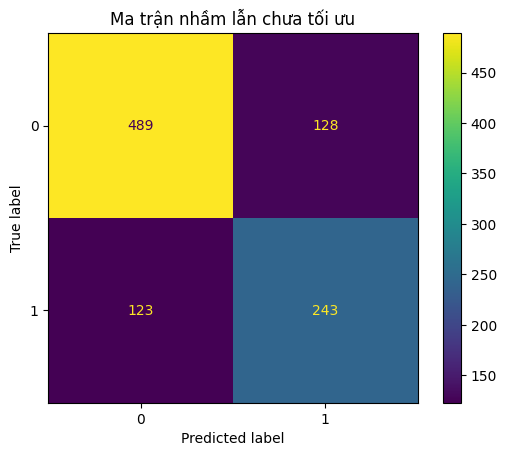

In [38]:
ConfusionMatrixDisplay.from_estimator(decision_tree, X_test, y_test)
plt.title("Ma trận nhầm lẫn chưa tối ưu")

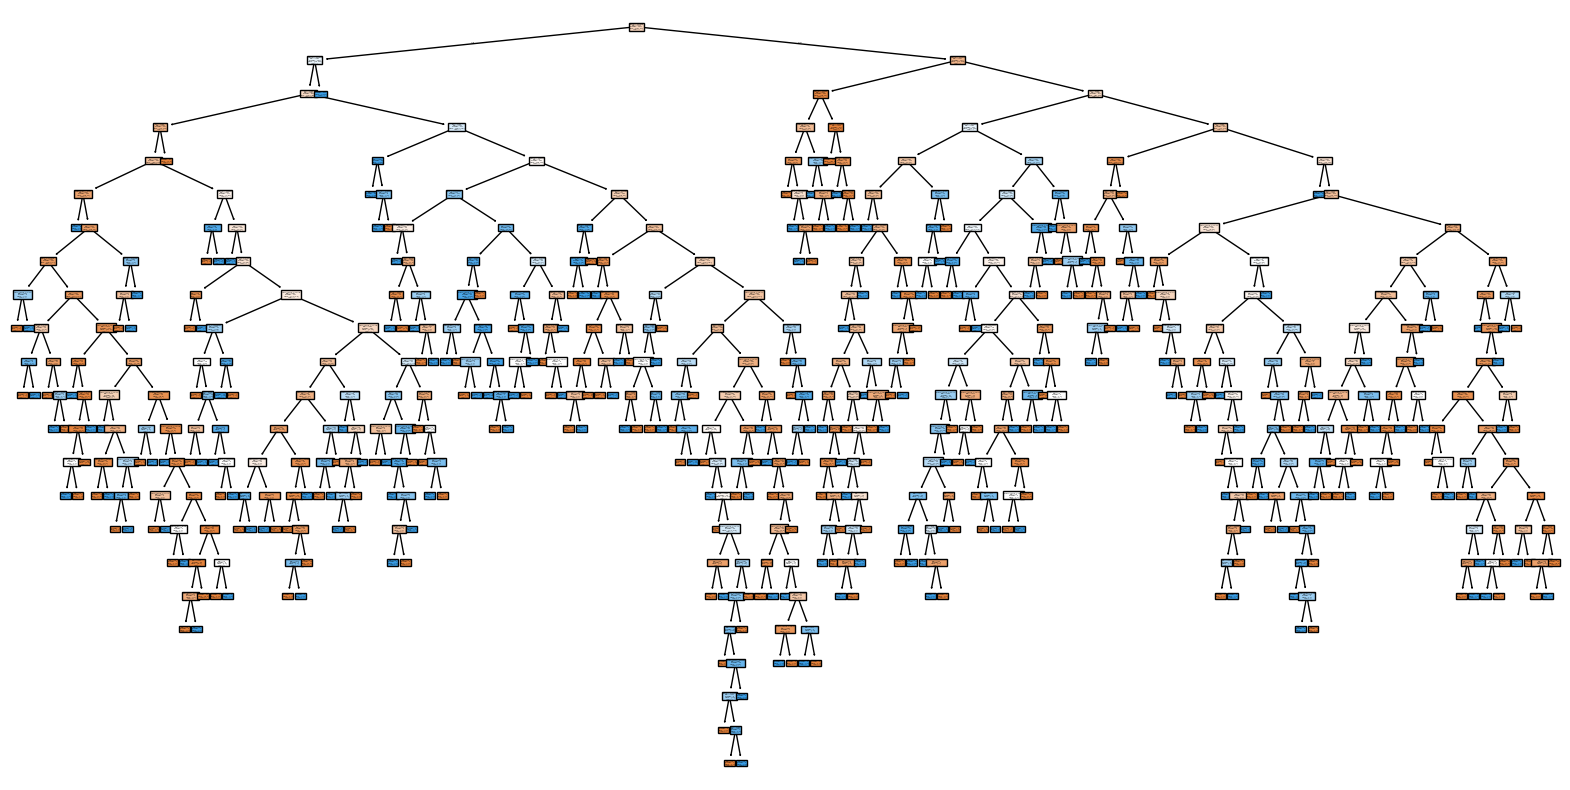

In [21]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=df.columns[:-1], class_names=['0', '1'])
plt.show()

# Cây chưa tối ưu

# Tối ưu mô hình

In [22]:
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'criterion': ['entropy'],
    'class_weight': [None, 'balanced']
}

In [23]:
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['entropy'], 'max_depth': [5, 10, None],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10]},
             scoring='precision', verbose=1)

In [24]:
grid_search.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [25]:
best_decision_tree = grid_search.best_estimator_

In [26]:
y_proba = grid_search.predict_proba(X_test)[:, 1]

In [27]:
# Tạo 1 chuỗi threshold (ngưỡng) từ 0.0 đến 1.0, bước nhảy 0.01
threshold = np.arange(0.0, 1.01, 0.01)

# 1 mảng lưu kết quả từ confusion matrix (ma trận nhầm lẫn)
res = []

In [28]:
for t in threshold:
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    res.append((t, fp, fn, tp, tn))

In [29]:
df_thresh = pd.DataFrame(res, columns=['Threshold', 'FP', 'FN', 'TP', 'TN'])
df_thresh['Precision'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FP'])
df_thresh['Recall'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FN'])

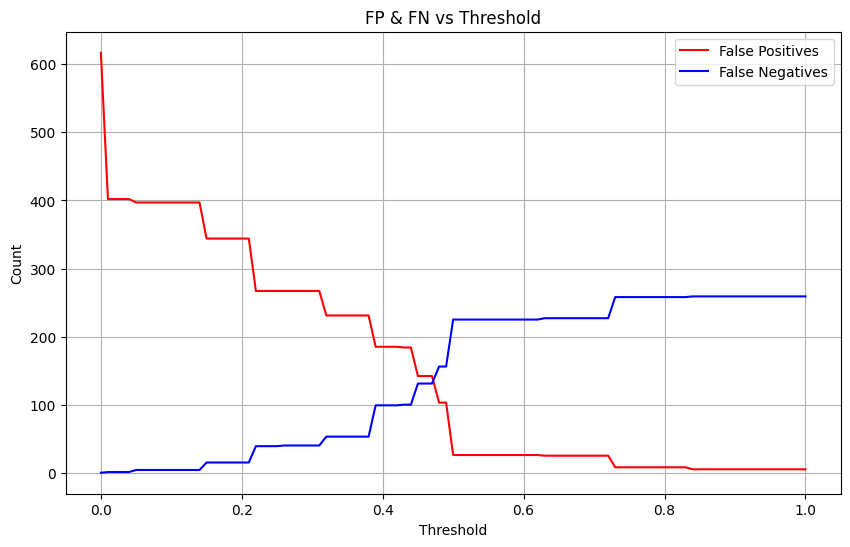

In [30]:
plt.figure(figsize=(10,6))
plt.plot(df_thresh["Threshold"], df_thresh["FP"], label="False Positives", color="red")
plt.plot(df_thresh["Threshold"], df_thresh["FN"], label="False Negatives", color="blue")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.title("FP & FN vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Vẽ biểu đồ ngưỡng FP và FN theo Threshold

In [31]:
# In ra confusion matrix theo nhiều threshold khác nhau
for t in threshold:
    print(f"Threshold: {t:.2f}")
    y_pred = (y_proba >= t).astype(int)
    print(confusion_matrix(y_test, y_pred))

Threshold: 0.00
[[  0 617]
 [  0 366]]
Threshold: 0.01
[[215 402]
 [  1 365]]
Threshold: 0.02
[[215 402]
 [  1 365]]
Threshold: 0.03
[[215 402]
 [  1 365]]
Threshold: 0.04
[[215 402]
 [  1 365]]
Threshold: 0.05
[[220 397]
 [  4 362]]
Threshold: 0.06
[[220 397]
 [  4 362]]
Threshold: 0.07
[[220 397]
 [  4 362]]
Threshold: 0.08
[[220 397]
 [  4 362]]
Threshold: 0.09
[[220 397]
 [  4 362]]
Threshold: 0.10
[[220 397]
 [  4 362]]
Threshold: 0.11
[[220 397]
 [  4 362]]
Threshold: 0.12
[[220 397]
 [  4 362]]
Threshold: 0.13
[[220 397]
 [  4 362]]
Threshold: 0.14
[[220 397]
 [  4 362]]
Threshold: 0.15
[[273 344]
 [ 15 351]]
Threshold: 0.16
[[273 344]
 [ 15 351]]
Threshold: 0.17
[[273 344]
 [ 15 351]]
Threshold: 0.18
[[273 344]
 [ 15 351]]
Threshold: 0.19
[[273 344]
 [ 15 351]]
Threshold: 0.20
[[273 344]
 [ 15 351]]
Threshold: 0.21
[[273 344]
 [ 15 351]]
Threshold: 0.22
[[350 267]
 [ 39 327]]
Threshold: 0.23
[[350 267]
 [ 39 327]]
Threshold: 0.24
[[350 267]
 [ 39 327]]
Threshold: 0.25
[[350 267

In [32]:
# Chọn ngưỡng 0.84
y_pred_best = (y_proba >= 0.84).astype(int)

Text(0.5, 1.0, 'Ma trận nhầm lẫn đã tối ưu')

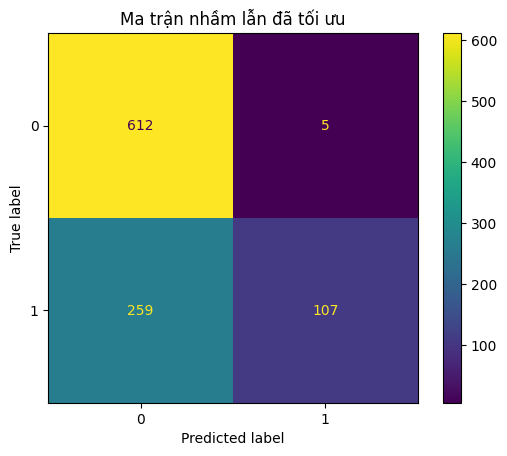

In [37]:
cm_best = confusion_matrix(y_test, y_pred_best)
display_cm_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
display_cm_best.plot()
plt.title("Ma trận nhầm lẫn đã tối ưu")

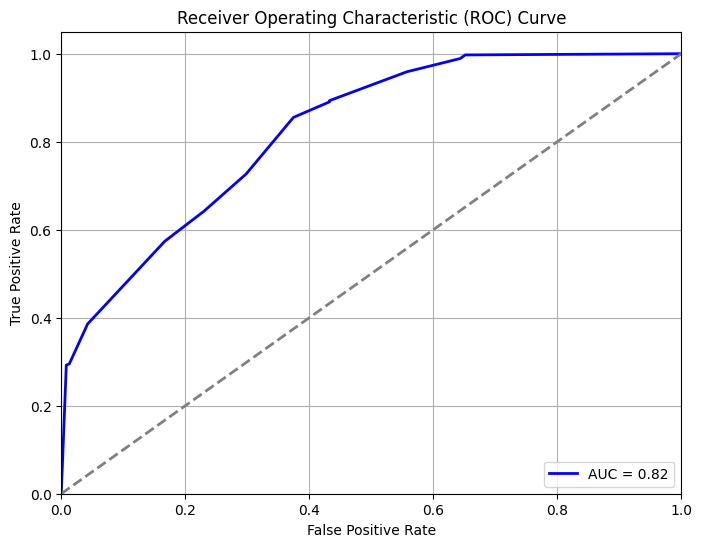

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

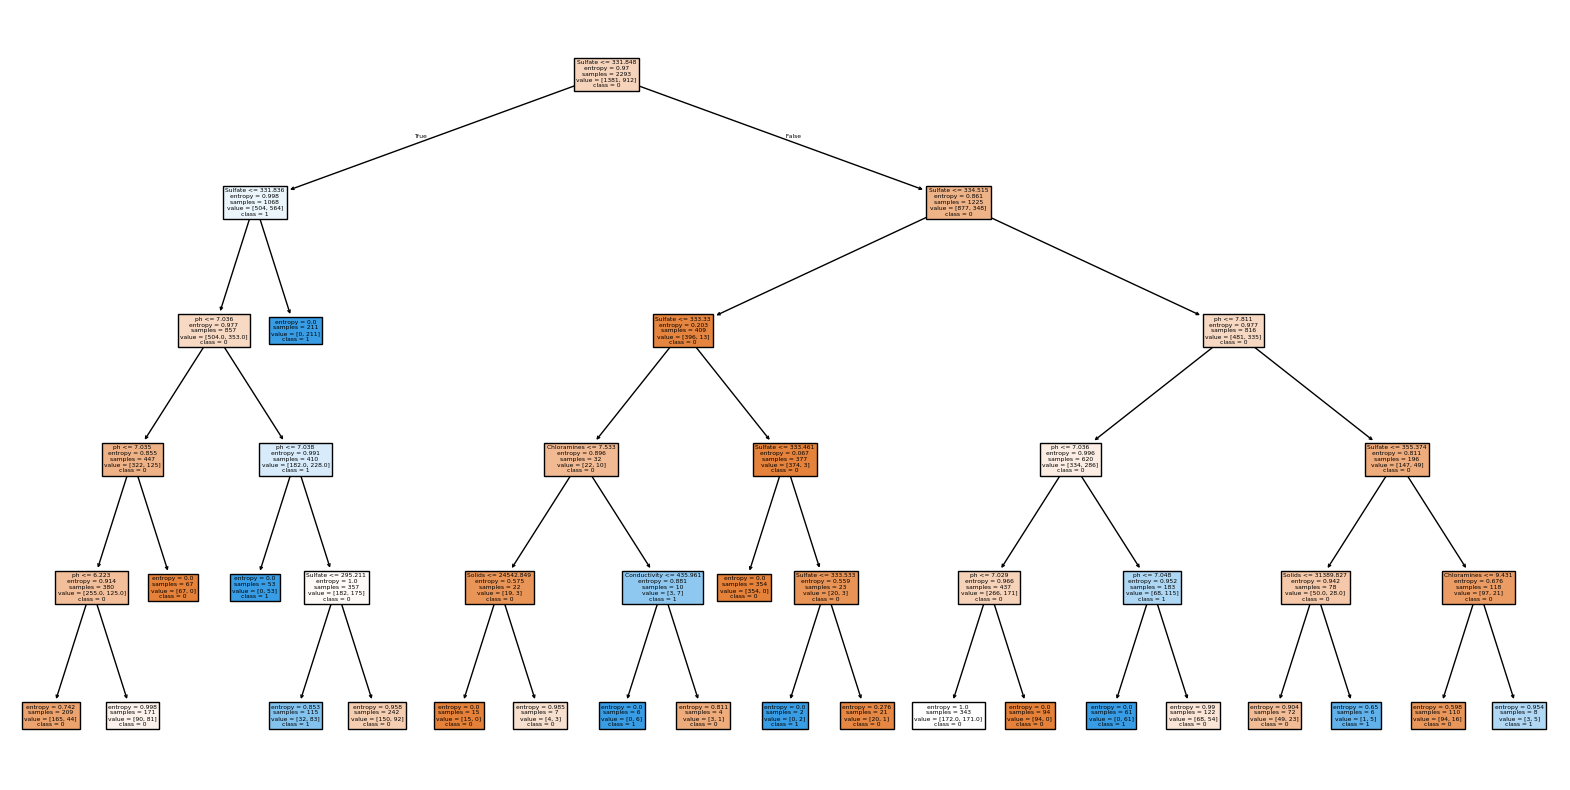

In [35]:
best_decision_tree = grid_search.best_estimator_

plt.figure(figsize=(20,10))
plot_tree(best_decision_tree, filled=True, feature_names=df.columns[:-1], class_names=['0', '1'])
plt.show()

# Cây đã tối ưu

In [36]:
def check_importance(model, feature_names):
	importances = model.feature_importances_
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

check_importance(best_decision_tree, df.columns[:-1])

           Feature  Importance
4          Sulfate    0.620788
0               ph    0.348227
3      Chloramines    0.014267
2           Solids    0.010828
5     Conductivity    0.005890
1         Hardness    0.000000
6   Organic_carbon    0.000000
7  Trihalomethanes    0.000000
8        Turbidity    0.000000
